# Mass of B5-IRS1 from the C$^{18}$O emission

In [1]:
%matplotlib widget
import numpy as np
from astropy.io import fits
from pvextractor import Path, extract_pv_slice, PathFromCenter
from spectral_cube.spectral_cube import SpectralCube
from astropy.coordinates import SkyCoord
import sys
import os
sys.path.append('../B5_NOEMA_30m')
from B5setup import *
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.constants import G
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

## Obtain the position velocity diagram

In [2]:
lengtharcsec = 12 # in arcsec
widtharcsec = 0.44 # beam major
#centerra, centerdec = (ra_yso*u.deg, dec_yso*u.deg) # in degrees
centerra, centerdec = ((3+(47+(41.587/60))/60)*15 *u.deg, (32+(51+43.616/60)/60)*u.deg) # center of continuum emission
# pvextractor considers 0deg as South to North, we want to go approx. North to South
paangle = (67.1  -90 + 180) * u.deg # degrees, perpendicular to outflow and then N to S instead of S to N
cubename = 'cleaned_images/B5IRS1_C18O_robust05_multi.fits'
cubenameK = 'cleaned_images/B5IRS1_C18O_robust05_multi_K.fits'
pvfilename = 'cleaned_images/B5IRS1_C18O_robust05_multi_K_PV_'+str(paangle)+'deg_'+str(lengtharcsec)+'arcsec_'+str(widtharcsec)+'width_cont_centered.fits'
pvarcsecfilename = 'cleaned_images/B5IRS1_C18O_robust05_multi_K_PV_'+str(paangle)+'deg_'+str(lengtharcsec)+'arcsec_'+str(widtharcsec)+'width_cont_centered_arcsec.fits'

velinit = 7 * u.km/u.s
velend = 13 * u.km/u.s 

In [3]:
if not os.path.exists(cubenameK):
    cube = SpectralCube.read(cubename)
    cube.allow_huge_operations=True
    cube = cube.to(u.K)
    cube.write(cubenameK)
    cube = cube.spectral_slab(velinit, velend)
else:
    cube = SpectralCube.read(cubenameK).spectral_slab(velinit, velend)

if not os.path.exists(pvfilename):
    gcent = SkyCoord(centerra, centerdec)
    pathcent = PathFromCenter(center=gcent, length=lengtharcsec*u.arcsec, angle=paangle, width=widtharcsec*u.arcsec)
    slice1 = extract_pv_slice(cube, pathcent)
    slice1.header['CRPIX1'] = int(slice1.header['NAXIS1']/2) # by default the reference offset is the first pixel
    slice1.writeto(pvfilename)

if not os.path.exists(pvarcsecfilename):
    pvdata = fits.getdata(pvfilename)
    pvheader = fits.getheader(pvfilename)
    pvdata = np.flip(pvdata, axis=0) # so that the velocities grow instead of decreasing
    pvheader['CDELT1'] = pvheader['CDELT1']*3600 # we just change the unit to be able to use it with Cote's code
    pvheader['CUNIT1'] = 'arcsec'
    if np.sign(pvheader['CDELT2'])<0:
        velinit = pvheader['CRVAL2'] + pvheader['CDELT2'] * (pvheader['NAXIS2'] - pvheader['CRPIX2']) # this is the velocity in the new first pixel
        pvheader['CRPIX2'] = 1 # the first pixel is our new reference
        pvheader['CRVAL2'] = velinit # the first pixel will have the lowest velocity
        pvheader['CDELT2'] *= -1 
    hdu = fits.PrimaryHDU(data=pvdata, header=pvheader)
    hdu.writeto(pvarcsecfilename)
    

## Plot the mass and its keplerian rotation

In [4]:
def v_kepler(mass, radius):
    vel = np.sqrt(G * mass / radius)
    return vel

def v_infall_rot(radius, j0):
    vel = j0 / radius
    return vel

In [5]:
# constants to test 
v_lsr = 10.2 *u.km/u.s # km/s
mass_IRS1 = np.array([0.1, 0.2]) * u.Msun # Msun
inclination = 77 # degrees, inclination of the disk
arcsectoau = 302 # pc

In [6]:
pvdata = fits.getdata(pvfilename)
pvheader = fits.getheader(pvfilename)

# The position velocity file is designed for the middle of the offset array to
# be the position of the protostar, but the original file has offset=0 as one of 
# the extremes of the pvcut
delta0 = pvheader['CRVAL1']
delta_delta = pvheader['CDELT1']
delta_pix0 = pvheader['CRPIX1']
delta_npix = pvheader['NAXIS1']
vel0 = pvheader['CRVAL2']
delta_vel = pvheader['CDELT2']
vel_pix0 = pvheader['CRPIX2']
vel_npix = pvheader['NAXIS2']

delta_array = np.array([delta0 + delta_delta*(i-delta_pix0) for i in range(delta_npix)]) * u.deg
vel_array = np.array([vel0 + delta_vel * (i - vel_pix0) for i in range(vel_npix)]) * u.m/u.s

# transformation to general coordinates
vel_array = vel_array.to(u.km/u.s)
offset_array = (delta_array).to(u.arcsec)
distance_array = offset_array.value * arcsectoau * u.au
# we create the meshgrid to plot
offset, vel = np.meshgrid(distance_array, vel_array)

In [7]:
# here we calculate the keplerian curves
radius = np.linspace(20, 1000, 1000) * u.au
radius_neg = np.linspace(-20, -1000, 1000) * u.au
velocity_peri = []
velocity_neg_peri = []
for m in mass_IRS1:
    velocity = v_kepler(m, radius).to(u.km/u.s) * np.sin(inclination*np.pi/180)
    velocity_pos = velocity + v_lsr
    velocity_neg = -1*velocity + v_lsr
    velocity_peri.append(velocity_pos)
    velocity_neg_peri.append(velocity_neg)

In [8]:
# here we calculate infall rotation curves
r_CB = 200 * u.au
j = np.sqrt(r_CB * (2 * G  * mass_IRS1[1])).decompose()

velocit_inf = v_infall_rot(radius, j).to(u.km/u.s) * np.sin(inclination*np.pi/180)+ v_lsr
velocit_inf_neg = v_infall_rot(radius_neg, j).to(u.km/u.s) * np.sin(inclination*np.pi/180)+ v_lsr

AttributeError: 'float' object has no attribute 'value'

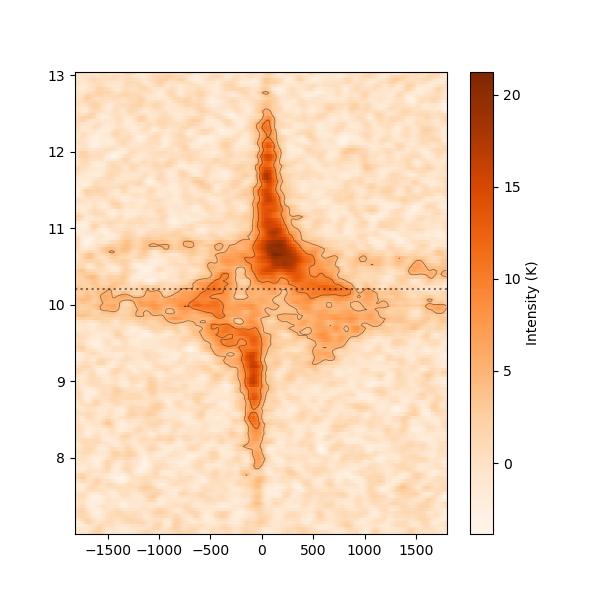

In [9]:
# here we plot the result
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
pcolor = ax.pcolor(offset.value, vel.value, pvdata, shading='auto', cmap='Oranges')
contours = ax.contour(offset.value, vel.value, pvdata, 0.9*np.array([5, 10]), colors='k', linewidths=0.5, alpha=0.5)
fig.colorbar(pcolor, ax=ax, label=r'Intensity (K)')
linestyles = ['--',':']
ax.axhline(v_lsr.value, color='k', ls=':', alpha=0.5)
ax.set_ylim([velinit.value, velend.value])
for i, m in enumerate(mass_IRS1):
    ax.plot(radius, velocity_peri[i], color='k', ls=linestyles[i], label=r'$M_{\star}='+str(m.value)+r'M_{\odot}$')
    ax.plot(radius_neg, velocity_neg_peri[i], color='k', ls=linestyles[i])
ax.plot(radius, velocit_inf, color='C0', label='Infall')
ax.plot(radius_neg, velocit_inf_neg, color='C0')
ax.legend()
bar = AnchoredSizeBar(ax.transData, 120, '120 au', 2, pad=0.1, borderpad=0.5, sep=5,  frameon=False, color='k')#, size_vertical=0.08)
ax.add_artist(bar)
ax.set_xlabel('Offset (au)')
ax.set_ylabel(r'Velocity (km s$^{-1}$)')
# ax.invert_yaxis()

# fig.savefig('pvdiag_C18O_'+str(paangle)+
           #  '_'+str(lengtharcsec)+'arcsec_'+str(widtharcsec)+
           #  'width_kepler'+str(inclination)+'inc_M_nocont.pdf',
           # bbox_inches='tight')


In [ ]:
from astropy.modeling import models, fitting
from spectral_cube import BooleanArrayMask
from gaussfitter import gaussfitter
smallcubename = 'cleaned_images/B5IRS1_C18O_robust05_multi_cut_pbcor.fits'
smallcubenameK = 'cleaned_images/B5IRS1_C18O_robust05_multi_cut_pbcor_K.fits'
rmsfile = 'cleaned_images/B5IRS1_C18O_robust05_multi_cut_pbcor_K_rms.fits'
snrfile = 'cleaned_images/B5IRS1_C18O_robust05_multi_cut_pbcor_K_SNR.fits'

In [ ]:
if not os.path.exists(smallcubenameK):
    print('Creating file in K')
    smallcube = SpectralCube.read(smallcubename)
    smallcube.allow_huge_operations=True
    smallcube = smallcube.to(u.K)
    smallcube.write(smallcubenameK)
    smallcube = smallcube.spectral_slab(velinit, velend)
else:
    smallcube = SpectralCube.read(smallcubenameK)
    
hdcube = smallcube.header.copy()
key_remove = ['NAXIS3','CRPIX3','CDELT3','CUNIT3','CTYPE3','CRVAL3','SPECSYS']
for key_i in key_remove:
    hdcube.remove(key_i)
hdcube['WCSAXES'] = 2
hdcube['NAXIS'] = 2

if not os.path.exists(rmsfile):
    print('Creating rms map')
    velinitrms = 4.5 *u.km/u.s
    rmsmap = smallcube.spectral_slab(velinitrms, velinit).unmasked_data[:,:,:].std(axis=0)
    fits.writeto(rmsfile, rmsmap.value, hdcube)
else:
    rmsmap = fits.getdata(rmsfile) * u.K
    
if not os.path.exists(snrfile):
    print('Creating Signal to Noise Ratio cube')
    Tpeakmap = smallcube.unmasked_data[:,:,:]
    snrmap = (Tpeakmap / rmsmap).value
    snrhdcube = smallcube.header.copy()
    snrhdcube['CUNIT3'] = ''
    fits.writeto(snrfile, snrmap, hdcube)
else: if not os.path.exists(smallcubenameK):
    print('Creating file in K')
    smallcube = SpectralCube.read(smallcubename)
    smallcube.allow_huge_operations=True
    smallcube = smallcube.to(u.K)
    smallcube.write(smallcubenameK)
    smallcube = smallcube.spectral_slab(velinit, velend)
else:
    smallcube = SpectralCube.read(smallcubenameK)
    
hdcube = smallcube.header.copy()
key_remove = ['NAXIS3','CRPIX3','CDELT3','CUNIT3','CTYPE3','CRVAL3','SPECSYS']
for key_i in key_remove:
    hdcube.remove(key_i)
hdcube['WCSAXES'] = 2
hdcube['NAXIS'] = 2

if not os.path.exists(rmsfile):
    print('Creating rms map')
    velinitrms = 4.5 *u.km/u.s
    rmsmap = smallcube.spectral_slab(velinitrms, velinit).unmasked_data[:,:,:].std(axis=0)
    fits.writeto(rmsfile, rmsmap.value, hdcube)
else:
    rmsmap = fits.getdata(rmsfile) * u.K
    
if not os.path.exists(snrfile):
    print('Creating Signal to Noise Ratio cube')
    Tpeakmap = smallcube.unmasked_data[:,:,:]
    snrmap = (Tpeakmap / rmsmap).value
    snrhdcube = smallcube.header.copy()
    snrhdcube['CUNIT3'] = ''
    fits.writeto(snrfile, snrmap, hdcube)
else: 
    snrmap = fits.getdata(snrfile)

print('Loaded initial files, ready to fit')
    snrmap = fits.getdata(snrfile)

print('Loaded initial files, ready to fit')


In [ ]:
velinitblue = 7.5* u.km / u.s
velendblue =7.9 * u.km / u.s
velinitred = 12 * u.km / u.s
velendred =14* u.km / u.s

maskcube = BooleanArrayMask(mask=snrmap>3, wcs=smallcube.wcs)
smallcube = smallcube.with_mask(maskcube)
maskcubefile = 'cleaned_images/B5IRS1_C18O_robust05_multi_cut_pbcor_K_masked.fits'
if not os.path.exists(maskcubefile):
    fits.writeto(maskcubefile, smallcube.filled_data[:,:,:].value, smallcube.header)
smallmapblue = smallcube.spectral_slab(velinitblue, velendblue)
smallmapred = smallcube.spectral_slab(velinitred, velendred)


In [ ]:
# there must be at least 10 pixels within a radius of 0.44 arcsec from the center of the continuum to attempt to fit

def distancepix(x, y, x0, y0):
    #confirm it supports np.array
    return np.sqrt((x - x0) ** 2 + (y - y0) ** 2)

def get_initial_params(mapchan_filtered):
    peakK = np.nanmax(mapchan_filtered)
    positionpeakK = np.unravel_index(np.nanargmax(mapchan_filtered), np.shape(mapchan_filtered))
    xstd = 0
    ystd = 0
    while True:
        xstd+=1
        if (mapchan_filtered[positionpeakK[0]+ystd, positionpeakK[1]+xstd] < peakK/1.6) or np.isnan(mapchan_filtered[positionpeakK[0]+ystd, positionpeakK[1]+xstd]): 
            break
        ystd+=1
        if (mapchan_filtered[positionpeakK[0]+ystd, positionpeakK[1]+xstd] < peakK/1.6) or np.isnan(mapchan_filtered[positionpeakK[0]+ystd, positionpeakK[1]+xstd]):
            break
    
    return peakK, positionpeakK[1], positionpeakK[0], xstd, ystd # peak, xmean and ymean, xsted and ysted



In [ ]:
smallcubehead = smallcube.header
wcs = WCS(smallcubehead)
centerxcont = wcs.celestial.wcs_world2pix([centerra.value], [centerdec.value],0)[0][0]
centerycont = wcs.celestial.wcs_world2pix([centerra.value], [centerdec.value],0)[1][0]
maxdistancepix = 0.44 / (smallcube.header['CDELT2'] * 3600)
xx, yy = np.mgrid[:smallcubehead['NAXIS1'], :smallcubehead['NAXIS2']]
distancemap = distancepix(xx, yy, centerxcont, centerycont)


In [ ]:
# we know it works for a normal channel

smallmapblue = smallmapblue.with_mask(distancemap<maxdistancepix)
velocitiesblue = smallmapblue.spectral_axis
smallmapred = smallmapred.with_mask(distancemap<maxdistancepix)
velocitiesred = smallmapred.spectral_axis
positionx = []
positiony = []
errorx = []
errory = []
velocity = []

for chan in range(len(velocitiesblue)):
    smallmapmasked = smallmapblue.filled_data[chan, :, :].value

    if len(np.where(~np.isnan(smallmapmasked))[1]) < 10:
        print('Blue Channel {} does not have enough pixels above SNR = 3 within the continuum to fit.'.format(chan))
        continue

    smallmaptofit = smallmapblue.unmasked_data[chan, :, :].value
    # initguesses = gaussfitter.moments(smallmaptofit, False, True, True)
    # # initparams = np.array([height,peakK, positionpeakx, positionpeaky, xfwhm/2.35, yfwhm/2.35, theta0])
    # params, paramerrs = gaussfitter.gaussfit(smallmaptofit, err=rmsmap.value, params=initguesses, return_error=True, quiet=False)

    peakK, positionpeakx, positionpeaky, xstddev, ystddev = get_initial_params(smallmapmasked)
    # print(peakK, positionpeakx, positionpeaky, xstddev, ystddev)
    g_model = models.Gaussian2D(amplitude=peakK, x_mean=positionpeakx, y_mean=positionpeaky, x_stddev= xstddev, y_stddev=ystddev)
    fitter = fitting.LevMarLSQFitter()
    params = fitter(g_model, xx, yy, smallmaptofit, weights=rmsmap.value)
    if fitter.fit_info['param_cov'] is None:
        continue
    errparams = np.sqrt(np.diag(fitter.fit_info['param_cov'])) # remember there is theta as well!
    positionx.append(params.x_mean.value)
    positiony.append(params.y_mean.value)
    errorx.append(errparams[1])
    errory.append(errparams[2])
    velocity.append(velocitiesblue[chan].value)

# for chan in range(len(velocitiesred)):
#     smallmapmasked = smallmapred.filled_data[chan, :, :].value

#     if len(np.where(~np.isnan(smallmapmasked))[1]) < 10:
#         print('Red Channel {} does not have enough pixels above SNR = 3 within the continuum to fit.'.format(chan))
#         continue

#     smallmaptofit = smallmapred.unmasked_data[chan, :, :].value
#     peakK, positionpeakx, positionpeaky, xstddev, ystddev = get_initial_params(smallmapmasked)
#     g_model = models.Gaussian2D(amplitude=peakK, x_mean=positionpeakx, y_mean=positionpeaky, x_stddev= xstddev, y_stddev=ystddev)
#     fitter = fitting.LevMarLSQFitter()
#     params = fitter(g_model, xx, yy, smallmaptofit, weights=rmsmap.value)
#     if fitter.fit_info['param_cov'] is None:
#         continue
#     errparams = np.sqrt(np.diag(fitter.fit_info['param_cov'])) # remember there is theta as well!
#     positionx.append(params.x_mean.value)
#     positiony.append(params.y_mean.value)
#     errorx.append(errparams[1])
#     errory.append(errparams[2])
#     velocity.append(velocitiesred[chan].value)


In [ ]:
distances = distancepix(np.array(positionx), np.array(positiony), centerxcont, centerycont)
errordistances = distancepix(np.array(errorx), np.array(errory), 0, 0)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(positionx-centerxcont, positiony-centerycont, c=velocity, cmap='RdYlBu_r', zorder=100)
ax.errorbar(positionx-centerxcont, positiony-centerycont, xerr=errorx, yerr=errory, fmt='.',color='k', zorder=0)
ax.axhline(0, color='k', ls=':')
ax.axvline(0, color='k', ls=':')
ax.set_xlabel('x displacement (pix)')
ax.set_ylabel('y displacement (pix)')
# ax2 = fig.add_subplot(122)
# ax2.imshow(smallmapblue.unmasked_data[chan, :, :]-params(xx, yy))